In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [81]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from collections import Counter
import matplotlib.pyplot as plt
import time

In [4]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1,batch_first=True, dropout_rate=0.0, rnn_type='GRU'):
        super(RNN, self).__init__()
        self.batch_first = batch_first
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_rate = dropout_rate
        self.rnn_type = rnn_type

        self.encoder = nn.Embedding(input_size, hidden_size)
        self.softmax = torch.nn.LogSoftmax(dim=2)
        
        if self.rnn_type == 'GRU':
            self.rnn = nn.GRU(hidden_size, hidden_size, n_layers, dropout=self.dropout_rate, batch_first=batch_first)
        else:
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers, dropout=self.dropout_rate, batch_first=batch_first)

        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, inputs):
        
        inputs = self.encoder(inputs)
        output, hidden = self.rnn(inputs)
        output = self.decoder(output)        
        output = self.softmax(output)
        return output,hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

(array([262., 969., 592., 427., 172., 127.,  61.,  19.,  20.,   6.,   5.,
          2.,   0.,   2.,   0.,   1.,   1.,   0.,   0.,   1.]),
 array([ 0. ,  3.6,  7.2, 10.8, 14.4, 18. , 21.6, 25.2, 28.8, 32.4, 36. ,
        39.6, 43.2, 46.8, 50.4, 54. , 57.6, 61.2, 64.8, 68.4, 72. ]),
 <a list of 20 Patch objects>)

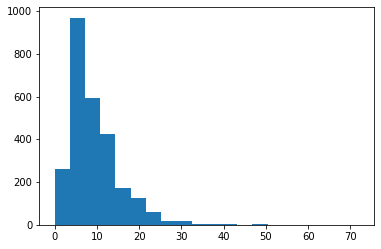

In [5]:
f = open("/content/drive/My Drive/datasets/Neplai Word Predictor/cleaned.txt", "r", encoding="utf8")
text = f.read()
f.close()
sentences = text.split("।")
words = []
sens_len = []
for s in sentences:
    w_s = s.split()
    sens_len.append(len(w_s))
    
    for w in s.split():
        words.append(w)
plt.hist(sens_len,20)

In [70]:
vocab_counter = Counter(words)
threshold = 2
vocab = ["<UNK>"]+[w for (w, c) in vocab_counter.most_common() if c >= threshold]

In [71]:
vocab_len = len(vocab)
vocab_len

2859

In [72]:
max_len = 30

In [73]:
def tensor_from_sentences(sentences,vocab, max_len=30):
    X = []
    Y = []
    vocab_len = len(vocab)
    for s in sentences:
        w_s = s.split()
#         print(w_s)
        idx_ip = [vocab.index(w) if w in vocab else 0 for w in w_s]
        len_words = len(idx_ip)
        
        if len_words < max_len:
            pad = [0] * (max_len - len_words)
            idx_ip += pad
        else :
            idx_ip = idx_ip[:max_len]
        
        idx_op = idx_ip[1:] + [0]
        one_hot = []
        for idx in idx_op:
            hot = [0] * vocab_len
            hot[idx] = 1
            one_hot.append(hot)
        
        X.append(idx_ip)
        Y.append(one_hot)
        
    return X,Y

X, Y = tensor_from_sentences(sentences, vocab, max_len)

In [98]:
def batchify(X,Y,batch_size):
    batches_X = []
    batches_Y = []
    len_data = len(X)
    for start in range(0,len_data,batch_size):
        end  = None
        if start + batch_size < len_data:
            end = start + batch_size
        else:
            end = len_data
            
        x = torch.tensor(X[start:end], dtype=torch.long)
        y = torch.tensor(Y[start:end], dtype=torch.float)
        
        batches_X.append(x)
        batches_Y.append(y)
    
    return batches_X, batches_Y

batches_X, batches_Y = batchify(X,Y, batch_size=100)

In [85]:
device = None
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

model = RNN(vocab_len,1000,vocab_len,2, rnn_type="LSTM").to(device)

In [108]:

def train(model, optimizer, criterion, epochs, train_X, train_Y):

    arch = "Model: {} \n Loss function: {} \n Optimizer: {}\n Batch size {}\n "\
      .format(str(model), str(criterion), str(optimizer), str(len(train_X[0])))
      
    hist_file = open("/content/drive/My Drive/models/Neplai Word Predictor/history.txt","a")
    hist_file.write(arch)

    start_time = time.time()
    for e in range(epochs):
        train_loss = 0
#         train_acc = 0

#         test_loss = 0
#         test_acc = 0
        
        for i in range(len(train_X)):
            x = train_X[i].to(device)
            y = train_Y[i].to(device)
            optimizer.zero_grad()
            prediction, hidden = model(x)
#             print(type(prediction))
            loss = criterion(prediction,y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.data.item()
#             train_acc += torch.eq(prediction.round(),y).sum().item()
        train_loss /= len(train_X)
#         train_acc /= len(train_X)
        rec = "Epoch {} Train Loss: {} in {} secs.\n".format(e+1, train_loss, time.time() - start_time)
        print(rec)
        hist_file.write(rec)
    hist_file.close()

#         for i in range(len(test_X)):
#             x = test_X[i].to(device)
#             y = test_Y[i:i+1].to(device)
#             y = y.float()
#             prediction = model(x)
#             prediction = prediction.squeeze(1)
#             loss = criterion(prediction,y)

#             test_loss += loss.data.item()
#             test_acc += torch.eq(prediction.round(),y).sum().item()
#         test_loss /= len(test_X)
#         test_acc /= len(test_X)

        # if (e+1)%10 == 0:
        #     torch.save(model, "/content/drive/My Drive/models/SA_LSTM/model/e_" + str(e+1)+".bin")
#         print("Epoch: {}  Training (loss,acc): ({},{})  Test (loss, acc):({},{})".format( e+1, train_loss, train_acc, test_loss, test_acc))

In [109]:
optimizer = torch.optim.Adam(model.parameters())
loss_fuction = nn.KLDivLoss()
train(model,optimizer,loss_fuction,30, batches_X,batches_Y)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2352: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Epoch 1 Train Loss: 7.210669018267827e-05 in 7.044266223907471 secs.
Epoch 2 Train Loss: 5.912860096604736e-05 in 14.098771810531616 secs.
Epoch 3 Train Loss: 5.2923477697832925e-05 in 21.150527477264404 secs.
Epoch 4 Train Loss: 4.895264013342697e-05 in 28.190850496292114 secs.
Epoch 5 Train Loss: 4.665198017998288e-05 in 35.23406529426575 secs.
Epoch 6 Train Loss: 4.49685347255716e-05 in 42.26276206970215 secs.
Epoch 7 Train Loss: 4.414337847804375e-05 in 49.27171564102173 secs.
Epoch 8 Train Loss: 4.256852574784447e-05 in 56.303473234176636 secs.
Epoch 9 Train Loss: 3.952604594006617e-05 in 63.3070170879364 secs.
Epoch 10 Train Loss: 3.743122511810658e-05 in 70.31932425498962 secs.
Epoch 11 Train Loss: 3.61713574184924e-05 in 77.33484935760498 secs.
Epoch 12 Train Loss: 3.535763223933625e-05 in 84.36265540122986 secs.
Epoch 13 Train Loss: 3.481324643804261e-05 in 91.37777280807495 secs.
Epoch 14 Train Loss: 3.446538465612792e-05 in 98.36888027191162 secs.
Epoch 15 Train Loss: 3.4145

In [110]:
def tensor_from_single_sent(sentence,vocab):
        words = sentence.split()
#         print(w_s)
        idx_ip = [vocab.index(w) if w in vocab else 0 for w in words]
        idx_ip = torch.tensor(idx_ip, dtype=torch.long)
        return idx_ip

In [111]:
def predict(model,sequence, vocab):
    sequence = sequence.to(device)
    sequence = torch.unsqueeze(sequence,0)
    prediction,_ = model(sequence)
    ip_op = []
    for i  in range(len(prediction)):
        sentence = prediction[i]
        seq = sequence[i].tolist()
        words_idx = torch.argmax(sentence, dim=1)
        words_idx = words_idx.tolist()
        seq += words_idx[-1:]
        ip_op.append(seq)
    
    actual_words = []
    for seq in ip_op:
        actual_words.append([vocab[idx] for idx in seq])
    return actual_words
t = 1941
seq = tensor_from_single_sent(sentences[t], vocab)
print(sentences[t])
predict(model, seq[:-2], vocab)  

 समुह वीचबाट अर्को बोल्यो 


[['<UNK>', '<UNK>', '<UNK>']]

In [116]:
hard_ip = input("Enter the nepali string: ")
seq = tensor_from_single_sent(hard_ip, vocab)
predict(model, seq, vocab) 

Enter the nepali string: म खाटमा


[['म', '<UNK>', '<UNK>']]

In [113]:
def count_parameters(model):
      return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

21736859